In [44]:
import yodo
import numpy as np

import plotly.express as ex

In [45]:
yodo.anchors.DEFAULT_CONFIG

{'img_size': 384, 'config': [{'anchor_grid': {'resize_factor': 32, 'k': 5, 'image_size': 384, 'box_gen': {'low': 8, 'high': 48}}, 'name': 'FPN0'}, {'anchor_grid': {'resize_factor': 64, 'k': 4, 'image_size': 384, 'box_gen': {'low': 48, 'high': 96}}, 'name': 'FPN1'}, {'anchor_grid': {'resize_factor': 128, 'k': 3, 'image_size': 384, 'box_gen': {'low': 96, 'high': 192}}, 'name': 'FPN2'}]}

In [93]:
anchor_config = yodo.utils.JSON({
    "img_size":384,
    "config":[
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 32, 
                    'k': 5, 
                    'image_size': 384, 
                    'box_gen': {
                        'low': 8, 
                        'high': 48
                    }
                }, 
            'name': 'FPN0'
        }),
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 64, 
                    'k': 3, 
                    'image_size': 384, 
                    'box_gen': {
                        'low': 48, 
                        'high': 128
                    }
                }, 
            'name': 'FPN1'
        }),
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 128, 
                    'k': 3, 
                    'image_size': 384, 
                    'box_gen': {
                        'low': 128, 
                        'high': 384
                    }
                }, 
            'name': 'FPN2'
        }),
    ]
})

In [94]:
parser = yodo.XMLParser("./datasets/CarLicensePlates/")

In [95]:
parser.parse()

In [96]:
parser

XMLParser @ C:\workspace\detect\datasets\CarLicensePlates

In [97]:
hw = parser.as_dataframe()[['h','w']] * anchor_config.img_size

In [98]:
ex.scatter(data_frame=hw,x='w',y='h')

In [99]:
anchors = yodo.Anchors(**anchor_config())

In [100]:
y_prob,y_boxes = anchors.encode_batch(parser)

In [101]:
y_prob.shape,y_boxes.shape

((433, 855, 2), (433, 855, 4))

In [81]:
images = yodo.utils.read_images(parser,yodo.anchors.DEFAULT_CONFIG.img_size).astype(np.float32) / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


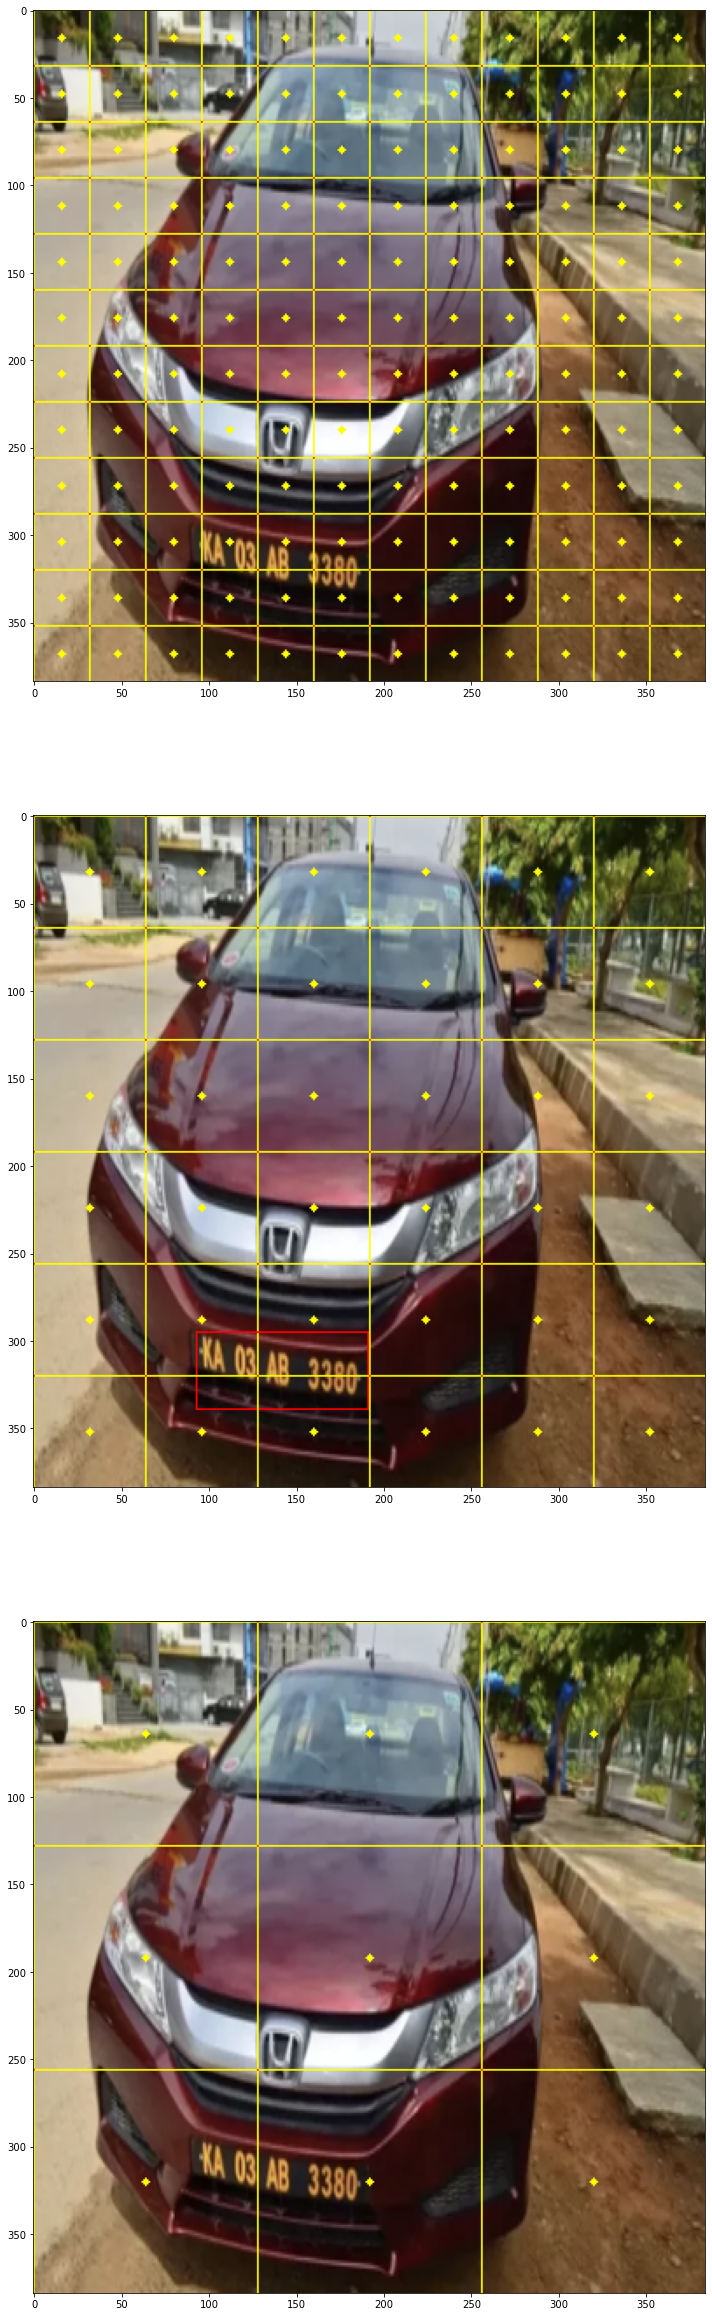

In [102]:
i = np.random.randint(0,len(images))
prob,boxes = anchors.encode(parser[i])
anchors.plot_grid(images[i],prob,boxes)

In [103]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [104]:
config = yodo.utils.JSON({
    "img_size":yodo.anchors.DEFAULT_CONFIG.img_size,
    "backbone":[
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_a",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_b",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_c",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_d",
                "pool":True
            }
        })
    ],
    "proposals":[
        yodo.utils.JSON({
            "k":5,
            "params":{
                "filters":64,
                "ksize":5,
                "name":"opn_0",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "k":3,
            "params":{
                "filters":256,
                "ksize":3,
                "name":"opn_1",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "k":3,
            "params":{
                "filters":1024,
                "ksize":3,
                "name":"opn_2",
                "pool":True
            }
        })
    ]
})

In [117]:
def schedule(epoch):
    if epoch > 100:
        return .000001
    elif epoch > 70:
        return .00001
    elif epoch > 10:
        return .0001
    else:
        return .001

In [118]:
lrs = LearningRateScheduler(schedule=schedule,verbose=1)
chk = ModelCheckpoint(filepath="./checkpoints/net",save_weights_only=True,monitor='loss')

In [119]:
yada = yodo.net.YODO(config=config)

In [120]:
optimizer = keras.optimizers.Adam()

In [121]:
yada.build(optimizer=optimizer,callbacks=[lrs,chk])

In [122]:
train,test = yodo.net.get_split(len(images),72)

In [123]:
train_flow = yodo.net.flow(120,images,(y_prob,y_boxes),train)

In [124]:
yada.train_generator(train_flow,len(train),120)

Train for 361 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/120
215/361 [================>.............] - ETA: 23s - loss: 1.8082 - prob_loss: 0.7272 - box_loss: 1.0810- ETA: 21s - loss: 1.8082 - prob_loss: 0.7272 - box_loss: 1.081

KeyboardInterrupt: 

In [23]:
class BoxLoss(tf.Module):
    """
    BoxLoss
    """
    def __init__(self,):
        self.__name__="BoxLoss"
        self.zero = tf.constant(0,tf.float32)
        self.one = tf.constant(1,tf.float32)
        self.two = tf.constant(2,tf.float32)
        self.l2_loss = tf.keras.losses.MeanSquaredError()

        self.slice_y = {"begin":[0,0,0],"size":[-1,-1,1]}
        self.slice_x = {"begin":[0,0,1],"size":[-1,-1,1]}
        self.slice_h = {"begin":[0,0,2],"size":[-1,-1,1]}
        self.slice_w = {"begin":[0,0,3],"size":[-1,-1,1]}
        
        self.repr = f"""
BoxLoss(
    
)
        """
        
    def __repr__(self,):
        return self.repr

    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        
        y = tf.slice(y_true,**self.slice_y)
        x = tf.slice(y_true,**self.slice_x)

        mask = tf.logical_or(tf.greater(y,self.zero),tf.greater(x,self.zero))

        y = y[mask] 
        x = x[mask] 
        h = tf.slice(y_true,**self.slice_h)[mask] 
        w = tf.slice(y_true,**self.slice_w)[mask] 

        y_ = tf.slice(y_pred,**self.slice_y)[mask] 
        x_ = tf.slice(y_pred,**self.slice_x)[mask] 
        h_ = tf.slice(y_pred,**self.slice_h)[mask] 
        w_ = tf.slice(y_pred,**self.slice_w)[mask] 
        
        w2  = tf.divide(w,self.two)
        h2  = tf.divide(h,self.two)
        w2_  = tf.divide(w_,self.two)
        h2_  = tf.divide(h_,self.two)
        
        xmin = tf.subtract(x,w2)
        xmax = tf.add(x,w2)
        ymin = tf.subtract(y,h2)
        ymax = tf.add(y,h2)
        
        xmin_ = tf.subtract(x_,w2_)
        xmax_ = tf.add(x_,w2_)
        ymin_ = tf.subtract(y_,h2_)
        ymax_ = tf.add(y_,h2_)
        
        Cymin = tf.maximum(ymin,ymin_)
        Cymax = tf.minimum(ymax,ymax_)
        Cxmin = tf.maximum(xmin,xmin_)
        Cxmax = tf.minimum(xmax,xmax_)

        Ch = tf.subtract(Cymax , Cymin)
        Cw = tf.subtract(Cxmax , Cxmin)
        
        Aa = tf.multiply( h , w )
        Ba = tf.multiply( h_ , w_ )
        Ca = tf.multiply( Cw , Ch )
        
        IoU = tf.reduce_mean(tf.subtract(self.one,tf.divide(Ca,tf.subtract(tf.add(Aa,Ba),Ca))))
        Xl2 = self.l2_loss(x,x_)
        Yl2 = self.l2_loss(y,y_)
        
        return Xl2 + Yl2 + IoU
